In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def plot_features_importances(model, Xcols) :
  imp_feats = pd.DataFrame(data=model.feature_importances_,index=Xcols, columns=['Feature Importance']).sort_values("Feature Importance")
  plt.figure(figsize=(14,6),dpi=200)
  sns.barplot(data=imp_feats.sort_values('Feature Importance'),x=imp_feats.sort_values('Feature Importance').index,y='Feature Importance')
  plt.xticks(rotation=90)
  plt.title("Feature Importance for Decision Tree");

# head

In [ ]:
df = pd.read_csv('train.csv')
df = df.drop(['PassengerId', 'Ticket', 'Name', 'Cabin'], axis = 1)
y = df['Survived']
X = df.drop('Survived', axis= 1)

survival : Survival	           :0 = No, 1 = Yes

pclass	 : Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex       : Sex

Age	     : Age in years

sibsp	   : # of siblings / spouses aboard the Titanic

parch	   : # of parents / children aboard the Titanic

ticket	 : Ticket number

fare	   : Passenger fare

cabin	   : Cabin number

embarked : Port of Embarkation : C = Cherbourg, Q = Queenstown, S = Southampton

In [ ]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
len(df)

891

In [ ]:
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [ ]:
df['Survived'] = df['Survived'].apply(lambda a : 'yes' if a==1 else 'no')

<ipython-input-416-a1fd88b30524>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Survived', ax=axes[0, 0], palette=['black', 'y']);


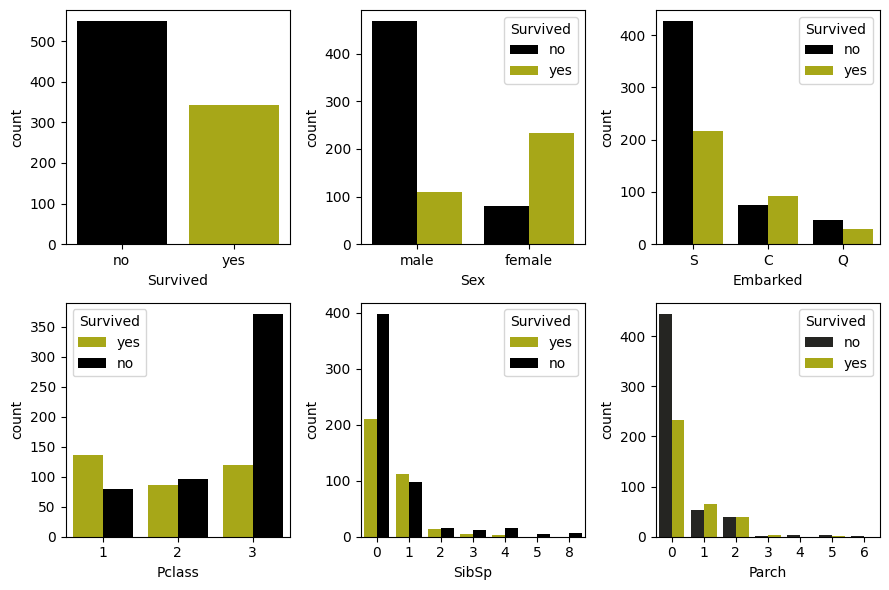

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6));
# plt.figure(figsize=(15,50))
plt.legend()
sns.countplot(data=df, x='Survived', ax=axes[0, 0], palette=['black', 'y']);
sns.countplot(data=df, x='Sex', ax=axes[0, 1], palette=['black', 'y'], hue='Survived');
sns.countplot(data=df, x='Embarked', ax=axes[0, 2], palette=['black', 'y'], hue='Survived');
sns.countplot(data=df, x='Pclass', ax=axes[1, 0], palette=['y', 'black'], hue='Survived');
sns.countplot(data=df, x='SibSp', ax=axes[1, 1], palette=['y', 'black'], hue='Survived');
sns.countplot(data=df, x='Parch', ax=axes[1, 2], palette='dark:y', hue='Survived');
plt.tight_layout();
plt.show();

**observations** :
- survival rate for men is way lower than for women
- the embarkation city has an impact on the survival
- the higher the class, the higher the chances of survival
- having no siblings/spouses or no parents/children decreases the chances of survival

# analysis on Age-->Survived relationship

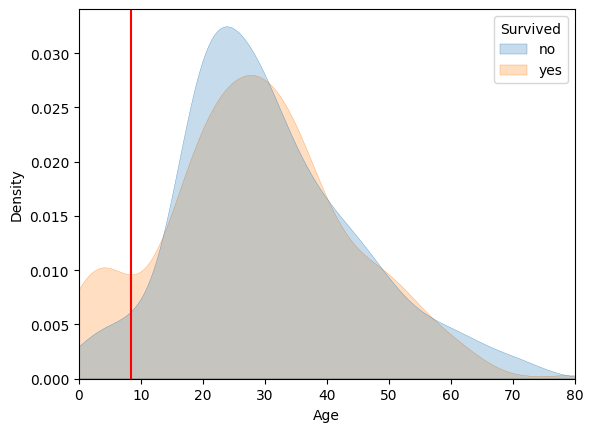

In [ ]:
sns.kdeplot(data=df, x='Age', hue='Survived', linewidth=0.2,  common_norm=False, fill=True)
# plt.xlim(-50,300)
plt.axvline(x=8.5, color='r', linestyle='-')
plt.xlim(0,80)
plt.show()

In [ ]:
df.groupby(['Survived']).count()['Pclass']

Survived
no     549
yes    342
Name: Pclass, dtype: int64

In [ ]:
len(df[df['Age']<8.5][df['Survived']=='yes'])

<ipython-input-25-87b04bba461a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df['Age']<8.5][df['Survived']=='yes'])


36

In [ ]:
len(df[df['Age']<8.5][df['Survived']=='no'])

<ipython-input-26-9c9f5040f53f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df['Age']<8.5][df['Survived']=='no'])


18

survival rate for age < 8.5 :

  36/(36+18) = 67% ±12% (95% confidence)

overall :
  
  343/(549+343) = 38% ±3% (95%confidence)

# analysis on Fare-->Survived relationship

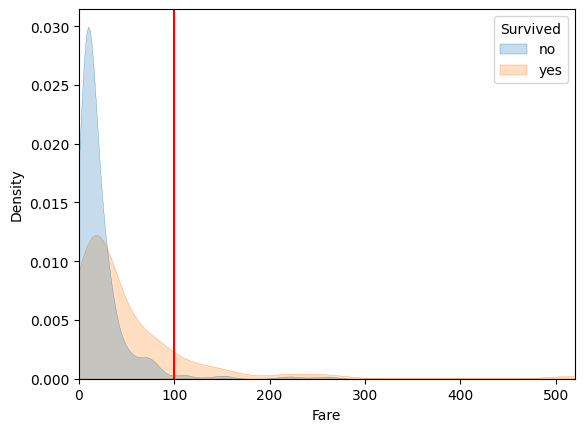

In [ ]:
sns.kdeplot(data=df, x='Fare', hue='Survived', linewidth=0.2,  common_norm=False, fill=True)
plt.xlim(0,520)
plt.axvline(x=100, color='r', linestyle='-')

In [ ]:
df.groupby(['Survived']).count()['Pclass']

Survived
no     549
yes    342
Name: Pclass, dtype: int64

In [ ]:
len(df[df['Fare']>100][df['Survived']=='yes'])

<ipython-input-29-3613f8a7ca94>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df['Fare']>100][df['Survived']=='yes'])


39

In [ ]:
len(df[df['Fare']>100][df['Survived']=='no'])

<ipython-input-30-e31545fbf633>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(df[df['Fare']>100][df['Survived']=='no'])


14

survival rate for fare > 100 :

  39/(39+14) = 73% ±12% (95%confidence)

overall :
  
  343/(549+343) = 38% ±3% (95%confidence)

# **Evaluation of models**

In [ ]:
dfm = df.dropna()

X = pd.get_dummies(dfm.drop('Survived', axis=1), dtype=int).drop('Sex_female', axis=1)
y = dfm['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)

## Decision Tree

In [ ]:
dtmodel = DecisionTreeClassifier()

# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 6, 12, 18],
# }

param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease':[0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.2]
}
dtmodelcv = GridSearchCV(dtmodel, param_grid, verbose=5)

In [ ]:
dtmodelcv.fit(X_train, y_train)

In [ ]:
pd.DataFrame(dtmodelcv.cv_results_)

In [ ]:
dtmodelcv.best_params_

{'criterion': 'gini', 'min_impurity_decrease': 0.01}

In [ ]:
dtmodel = DecisionTreeClassifier(**dtmodelcv.best_params_)
dtmodel.fit(X_train, y_train)

DecisionTreeClassifier(min_impurity_decrease=0.01)

In [ ]:
from sklearn.tree import plot_tree

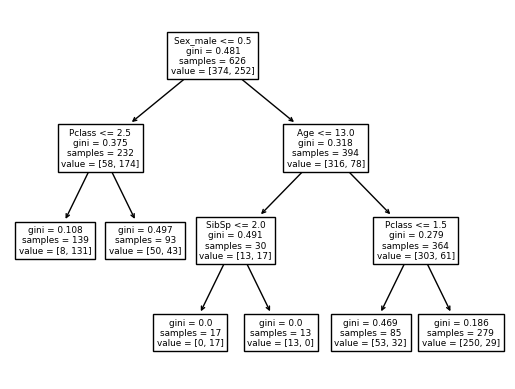

In [ ]:
plot_tree(dtmodel, feature_names=X.columns);

In [ ]:
preds = dtmodel.predict(X_test)

In [ ]:
accuracy_score(y_test, preds)

0.7906976744186046

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84        50
           1       0.91      0.56      0.69        36

    accuracy                           0.79        86
   macro avg       0.83      0.76      0.77        86
weighted avg       0.82      0.79      0.78        86



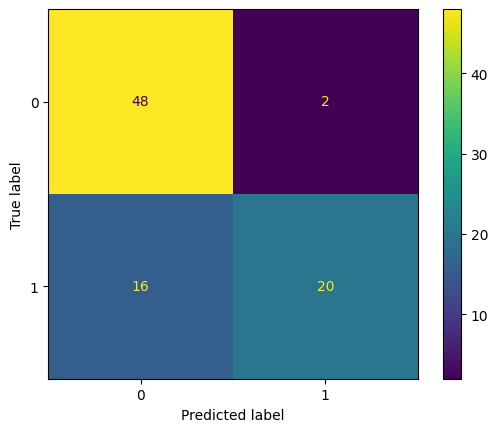

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels = dtmodel.classes_)
disp.plot()

In [ ]:
X.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')

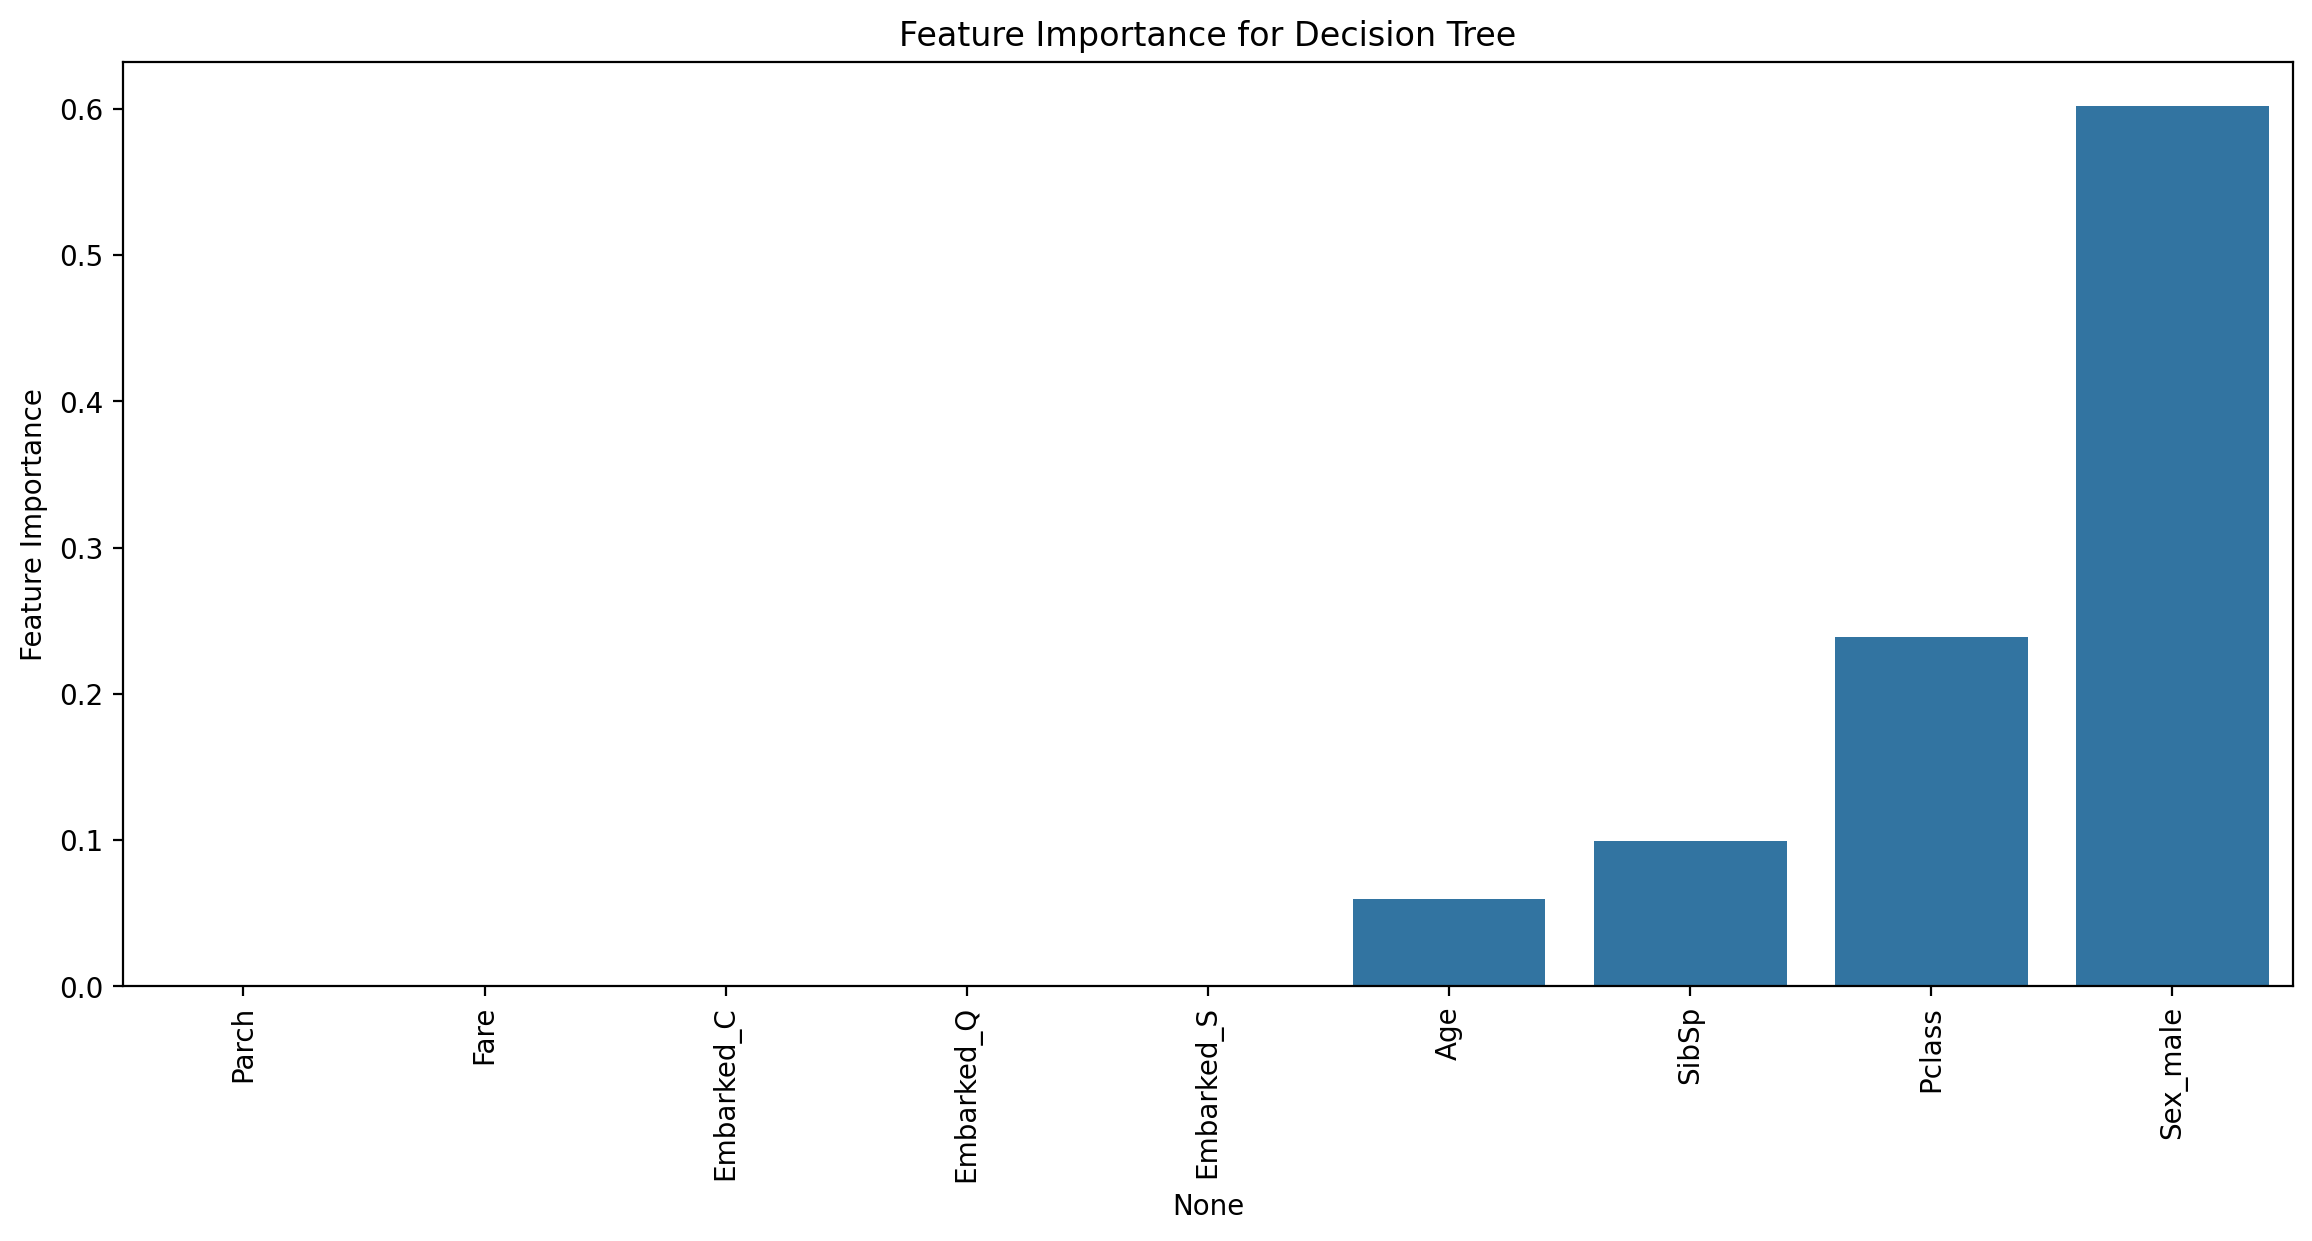

In [ ]:
plot_features_importances(dtmodel, X.columns)

## Random Forest

In [ ]:
# param_grid = {
#     'n_estimators': [32,64,100,128,200],  # Reduced number of options
#     'max_features': ['auto', 'sqrt'],  # 'log2' removed for simplicity
#     'max_depth': [2,4,6],  # Fewer depth options
# }


param_grid = {
    'n_estimators': [32,64,100,128],  # Reduced number of options
    'max_features': ['auto', 'sqrt'],  # 'log2' removed for simplicity
    'min_impurity_decrease':[0.002, 0.003, 0.004, 0.005, 0.01]
}

rfmodel = RandomForestClassifier()

rfmodelcv = GridSearchCV(rfmodel, param_grid)

In [ ]:
rfmodelcv.fit(X_train, y_train);

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

In [ ]:
rfmodelcv.best_params_

{'max_features': 'sqrt', 'min_impurity_decrease': 0.002, 'n_estimators': 128}

In [ ]:
rfmodel = RandomForestClassifier(max_features='sqrt', min_impurity_decrease=0.002, n_estimators=128)
rfmodel.fit(X_train, y_train)

RandomForestClassifier(min_impurity_decrease=0.002, n_estimators=128)

In [ ]:
preds = rfmodel.predict(X_test)

In [ ]:
accuracy_score(y_test, preds)

0.8023255813953488

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.88      0.61      0.72        36

    accuracy                           0.80        86
   macro avg       0.83      0.78      0.78        86
weighted avg       0.82      0.80      0.79        86



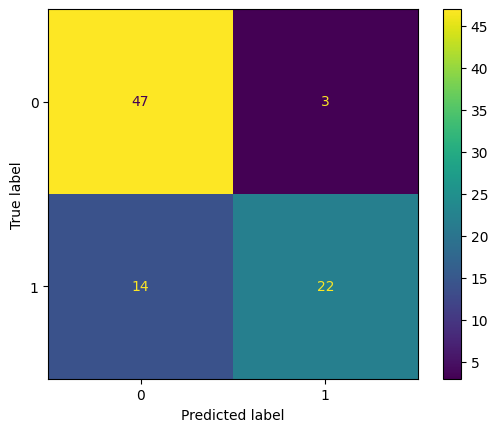

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds), display_labels = dtmodel.classes_).plot()

## Ada Boost Tree

In [ ]:
param_grid = {
    'n_estimators': [30, 50, 100, 200],       # Reasonable range to explore number of stages
    'learning_rate': [0.01, 0.1, 1, 2]       # Explore a range of learning rates
}

adamodel = AdaBoostClassifier()

adamodelcv = GridSearchCV(adamodel, param_grid)
adamodelcv.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 1, 2],
                         'n_estimators': [30, 50, 100, 200]})

In [ ]:
adamodelcv.best_params_

{'learning_rate': 1, 'n_estimators': 50}

In [ ]:
adamodel = AdaBoostClassifier(**adamodelcv.best_params_)

In [ ]:
adamodel.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=1)

In [ ]:
preds = adamodel.predict(X_test)

In [ ]:
accuracy_score(y_test, preds)

0.813953488372093

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84        50
           1       0.76      0.81      0.78        36

    accuracy                           0.81        86
   macro avg       0.81      0.81      0.81        86
weighted avg       0.82      0.81      0.81        86



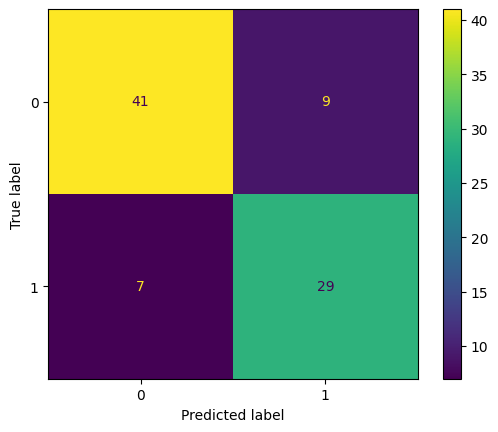

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels=adamodel.classes_).plot()

## Gradient boosted trees

In [ ]:
# param_grid = {
#     'n_estimators': [50, 80, 100, 200],             # exploring a moderate range
#     'learning_rate': [0.01, 0.1, 0.5, 1],      # commonly used learning rates
#     'max_depth': [3, 5, 7],                 # typical values for max_depth
# }

param_grid = {
    'n_estimators': [50, 80, 100, 200],             # exploring a moderate range
    'learning_rate': [0.01, 0.1, 0.5, 1],      # commonly used learning rates
    'min_impurity_decrease':[0.004, 0.005, 0.01]                 # typical values for max_depth
}

gradmodel = GradientBoostingClassifier()

gradmodelcv = GridSearchCV(gradmodel, param_grid)

gradmodelcv.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1],
                         'min_impurity_decrease': [0.004, 0.005, 0.01],
                         'n_estimators': [50, 80, 100, 200]})

In [ ]:
gradmodelcv.best_params_

{'learning_rate': 0.1, 'min_impurity_decrease': 0.004, 'n_estimators': 80}

In [ ]:
gradmodel = GradientBoostingClassifier(**gradmodelcv.best_params_)
gradmodel.fit(X_train, y_train)

GradientBoostingClassifier(min_impurity_decrease=0.004, n_estimators=80)

In [ ]:
preds = gradmodel.predict(X_test)
accuracy_score(y_test, preds)

0.8023255813953488

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.81      0.69      0.75        36

    accuracy                           0.80        86
   macro avg       0.80      0.79      0.79        86
weighted avg       0.80      0.80      0.80        86



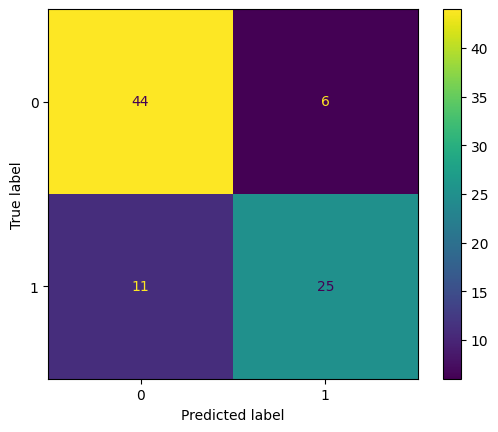

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels=gradmodel.classes_).plot()

## SVM

In [ ]:
# dfm = df.dropna()

# X = dfm.drop('Survived', axis=1)
# y = dfm['Survived']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)

In [ ]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Choice of C values that spans a range of orders of magnitude
    'kernel': ['rbf', 'poly', 'sigmoid'],  # Exploring common kernel types; 'linear' can be computationally intensive
    'gamma': ['scale', 'auto'],  # 'scale' and 'auto' are good defaults to compare
    'degree': [1, 2, 3, 4, 5, 6]  # Relevant only for 'poly' kernel; includes typical small integer values
}

svmodel= SVC()

svmodelcv = GridSearchCV(svmodel, param_grid, verbose=4)
svmodelcv.fit(scaled_X_train, y_train)

In [ ]:
svmodelcv.best_params_

{'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [ ]:
svmodel = SVC(C=1, degree=1, gamma='scale', kernel='rbf')
svmodel.fit(scaled_X_train, y_train)
preds = svmodel.predict(scaled_X_test)
accuracy_score(y_test, preds)

0.8023255813953488

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.83      0.67      0.74        36

    accuracy                           0.80        86
   macro avg       0.81      0.78      0.79        86
weighted avg       0.81      0.80      0.80        86



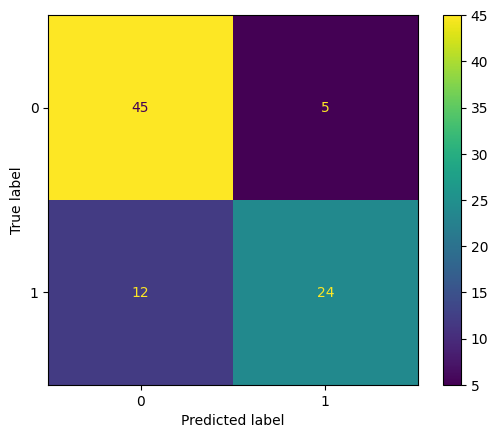

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels=svmodel.classes_).plot()

# **predictions on test data**

Our models have similar accuracy (around 0.80), witch could mean that the limits of our predictions are not related with the type of model itself but the potencial of prediction of our X features.

However, recalls and precisions are not the same, witch could lead to different model choices according to the needs. As accuracy is the target in our predictions, any model could work. For the purpose of diversity, we have chosen 2 models that work in a very different way to submit two sets of predictions on kaggle

## SVM Submission

In [ ]:
testX = pd.read_csv('test.csv')
testX = pd.get_dummies(testX.drop(['Ticket', 'Name', 'Cabin'], axis = 1), dtype=int).drop('Sex_female', axis=1)
testX.head()

tosend = pd.DataFrame(testX['PassengerId'])
testX = testX.drop('PassengerId', axis=1)
tosend.head()

imputer = SimpleImputer(strategy='mean')

imputed_testX = imputer.fit_transform(testX)

imputed_testX = pd.DataFrame(imputed_testX, columns=testX.columns)
imputed_testX.isna().sum()

scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_imputed_testX = scaler.transform(imputed_testX)

svmodel = SVC(C=1, degree=1, gamma='scale', kernel='rbf')
svmodel.fit(scaled_X, y)
preds = svmodel.predict(scaled_imputed_testX)

tosend['Survived']= preds

# Export the DataFrame to a CSV file
tosend.to_csv('mypredsSVM.csv', index=False)

accuracy reported in kaggle : **0.77** (vs 62% for a model that always predicts 0)

## RF submission

In [ ]:
testX = pd.read_csv('test.csv')
testX = pd.get_dummies(testX.drop(['Ticket', 'Name', 'Cabin'], axis = 1), dtype=int).drop('Sex_female', axis=1)
testX.head()

tosend = pd.DataFrame(testX['PassengerId'])
testX = testX.drop('PassengerId', axis=1)
tosend.head()

imputer = SimpleImputer(strategy='mean')
imputed_testX = imputer.fit_transform(testX)
imputed_testX = pd.DataFrame(imputed_testX, columns=testX.columns)

rfmodel = RandomForestClassifier(max_features='sqrt', min_impurity_decrease=0.002, n_estimators=128)
rfmodel.fit(X, y)
preds = rfmodel.predict(imputed_testX)

tosend['Survived']= preds

tosend['Survived'] = tosend['Survived'].apply(lambda surv: 1 if surv=='yes' else 0)

tosend.to_csv('mypredsRF.csv', index=False)

accuracy reported in kaggle : **0.79** (vs 62% for a model that always predicts 0)